# 线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。

In [2]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。

In [4]:
print('features:', features[0], '\nlabel', labels[0])

features: tensor([ 0.4584, -0.3539]) 
label tensor([6.3212])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。

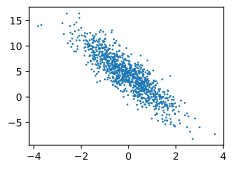

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8546, -1.0810],
        [-0.1999,  1.6383],
        [-0.5770,  0.8303],
        [ 1.4030,  0.3475],
        [ 1.2716, -0.1506],
        [-0.1707,  0.5623],
        [-0.6390,  1.0183],
        [-0.0131,  0.3161],
        [-1.4344, -0.5375],
        [-0.0566,  0.7780]]) 
 tensor([[ 9.6038],
        [-1.7543],
        [ 0.2245],
        [ 5.8258],
        [ 7.2631],
        [ 1.9314],
        [-0.5356],
        [ 3.1001],
        [ 3.1426],
        [ 1.4349]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
**在深度学习框架中实现的内置迭代器效率要高得多**，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用[微积分这章](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/01.preliminaries/05.autograd.ipynb)中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

注：torch.matmul() 没有强制规定维度和大小，可以用利用广播机制进行不同维度的相乘操作

In [9]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用[线性回归](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/01.linear-regression.ipynb)中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。

In [10]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在[线性回归](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/01.linear-regression.ipynb)中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [11]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # 在执行参数更新时，没有必要计算参数的梯度，这样只会浪费计算资源
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，会后面的章节中详细介绍。

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size, 1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        # w, b传递的是引用（传递Tensor作为参数时，传递的是Tensor的引用）
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    # 在推断过程中，通常不需要计算梯度，因为不涉及参数更新，使用with torch.no_grad可以减少内存的占用和不必要的计算开销。
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028061
epoch 2, loss 0.000102
epoch 3, loss 0.000049


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。

In [14]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([6.3300e-05, 3.4547e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0001], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？

### 1.练习一

如果将权重初始化为零，那么每个神经元的输出都是相同，这意味着每个神经元学习到的参数也是相同的。因此，每个神经元都会更新相同的参数，最终导致所有神经元学习到相同的特征。因此，权重初始化为零会使算法失效。这样就失去了神经网络的优势，即可以学习到不同特征的能力。

逻辑回归和神经网络有不同的权重初始化方法。对于逻辑回归，可以将权重初始化为零，因为这是一个线性模型，梯度下降算法仍然可以更新它们。然而，对于神经网络来说，将权重初始化为零可能会导致对称性问题，并阻止隐藏单元学习不同的特征。因此，最好使用随机或其他方法来初始化神经网络的权重。

（权重初始化为零，是因为在神经网络的前向传播过程中，每个神经元的输入是由其上一层的神经元输出与相应的权重相乘再求和得到的。由于所有的权重初始化为零，所以无论输入是什么，相乘后结果都为零，因此每个神经元接收到的输入都是相同的；当神经网络进行训练时，参数更新是根据梯度下降算法进行的，梯度告诉我们在当前位置沿着哪个方向可以减小损失函数。然而，如果所有神经元的权重都初始化为零，那么它们的梯度将相等，而且方向也相同。这意味着无论在何处，神经网络都会沿着同一个方向前进，就好像爬山者无论从山谷的哪个位置出发，都只能朝着同一个方向行进一样。由于所有神经元的权重更新方向相同，神经网络无法学习到复杂的特征表示，导致模型无法脱离初始状态，就像爬山者无法到达山顶一样。）

### 2.练习二

根据电压$U$与电流$I$的关系，可以构建模型：

$$U = w^TI + b$$

自动微分（Automatic Differentiation，简称AD）是一种对计算机程序进行高效准确求导的技术。他是介于符号微分和数值微分之间的一种方法，可以计算可导函数在某处的导数值的计算，是反向传播算法的一般化。

自动微分要解决的核心问题是计算复杂函数，通常是多层复合函数在某一点处的导数、梯度以及hessian矩阵值torch的backward就是自动微分。backward()函数会自动计算所有需要求导的变量的梯度，并将结果存储在相应变量的grad属性中。

根据书中对自动微分的描述：

深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。实际中，根据设计好的模型，系统会构建一个计算图（computational graph），来跟踪计算式哪些数据通过哪些操作组合起来产生输出。自动微分使系统能够随后反向传播梯度。这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

用代码验证电阻为30$Ω$的电流与电压的计算公式：

In [15]:
import torch

# 生成数据
x = torch.randn(100, 1)
y = 30 * x

# 定义模型
model = torch.nn.Linear(1, 1)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 训练模型
for epoch in range(500):
    # 前向传播
    y_pred = model(x)

    # 计算损失
    loss = criterion(y_pred, y)

    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(model.weight)
print(model.bias)

Parameter containing:
tensor([[29.9997]], requires_grad=True)
Parameter containing:
tensor([-5.2297e-05], requires_grad=True)


[这篇博客详细解释了为什么深度学习计算梯度选择反向累积](https://blog.csdn.net/m0_52380556/article/details/131929487)：

1. 比较省时间，不用每求一个变量的梯度就扫一遍；
2. 拿空间换时间，每个节点都存了梯度值，为求子节点梯度做准备，所有深度学习非常耗费GPU。

### 3.练习三

&emsp;&emsp;根据维基百科：

&emsp;&emsp;在物理学中，普朗克黑体辐射定律（也简称普朗克定律或黑体辐射定律）是指在任意温度$T$下，从一个黑体中发射出的电磁辐射的辐射率与频率之间的关系，在这里辐射率是频率$\nu$的函数：
$$
I_{\nu }(\nu ,T)={\frac {2h\nu ^{3}}{c^{2}}}{\frac {1}{e^{\frac {h\nu }{kT}}-1}}
$$
其中，$I_{\nu}$是辐射率，$\nu$是频率，$T$是黑体的温度，$h$是普朗克常数，$c$是光速，$k$是波茨曼常数。

根据电磁波波长和频率的关系为
$$
\lambda = \frac{c}{\nu}
$$

普朗克定律有时写做能量密度频谱的形式：

$$
u_{ \nu }{\nu ,T}
= \frac{4 \pi}{c} I_{\nu }(\nu ,T)
= \frac{8 \pi h \nu^{3}}{c^3} \frac {1}{e^{\frac {h\nu }{kT}} - 1}
$$

&emsp;&emsp;根据上述公式，可以得到物体的温度计算公式：
$$
T = \frac{h \nu}{K \ln \left( 1 + \displaystyle \frac{8 \pi h \nu^3}{c^3 u_{\nu}}\right)}
$$

&emsp;&emsp;通过测量物体发出的辐射能量密度，并使用普朗克定律可以确定物体的温度。

### 4.练习四

&emsp;&emsp;计算二阶导数时可能会遇到如下问题：

1. 数值不稳定性问题：该问题可以通过使用更高精度的数据类型（例如双精度浮点数）或通过使用数值稳定性技巧（例如中心查分）来解决。中心差分是一种常用的数值稳定性技巧，它可以用于计算函数在某点处的导数。具体来说，中心差分可以通过以下公式计算：

$$f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$$

&emsp;&emsp;其中$h$是一个很小的正数，通常取 $10^{-6}$ 或更小

2. 一阶导数的计算图保存问题：计算二阶导数，需要将一阶导数的计算图保存起来，使用create_graph和retain_graph参数

&emsp;&emsp;以下面函数举例：

- 原函数：$y = x^3$
- 一阶导函数：$y = 3 x^2$
- 二阶导函数：$y = 6 x$

In [16]:
import torch

x = torch.randn((2), requires_grad=True)
y = x ** 3

In [17]:
# 一阶导数
dy = torch.autograd.grad(y, x, grad_outputs=torch.ones(x.shape),
                        retain_graph=True, create_graph=True)

# 二阶导数
dy2 = torch.autograd.grad(dy, x, grad_outputs=torch.ones(x.shape))

In [18]:
dy[0] == 3 * x**2

tensor([True, True])

In [19]:
dy2[0] == 6 * x

tensor([True, True])

### 5.练习五

>```python
>def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
>```

&emsp;&emsp;函数是为了保证y和y_hat形状相同，避免触发广播机制导致错误的结果。

### 6.练习六

In [1]:
%matplotlib inline
import random
import torch
import numpy as np
from d2l import torch as d2l

In [2]:
# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [4]:
# 初始化参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [5]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [6]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [7]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [8]:
lrs = [0.5, 0.3, 0.1, 0.01]
num_epochs = 10
net = linreg
loss = squared_loss

batch_size = 10

all_lrs = []
for lr in lrs:
    train_lrs = []
    for epoch in range(num_epochs):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w, b), y) # X和y的小批量损失
            # 因为l的形状是(batch_size, 1), 而不是一个标量。l中的所有元素被加在一起
            # 并以此计算关于[w, b]的梯度
            l.sum().backward()
            sgd([w, b], lr, batch_size) # 使用参数的梯度
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            train_lrs.append(float(train_l.mean()))
    all_lrs.append(train_lrs)

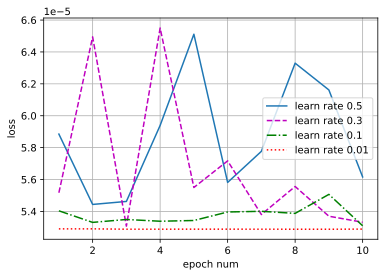

In [9]:
epochs = np.arange(1, num_epochs+1)
d2l.plot(epochs, all_lrs, xlabel='epoch num', ylabel='loss',
        legend=[f'learn rate {lr}' for lr in lrs],
        figsize=(6, 4))

&emsp;&emsp;根据上述实验结果，可得到如下结论：
1. 学习率过大前期损失值下降快，但是后面不容易收敛
2. 学习率太小，损失函数下降慢

### 7.练习七

&emsp;&emsp;如果样本个数不能被批量大小整除，则在最后一个迭代周期中，最后一批次可能包含少于批量大小个样本。在这种情况下，我们只需忽略该批次中多余的样本即可。例如，1000个总样本，batch_size=3, 那么最后1个样本会被舍去。